# Question 1

We begin my making a few assumptions.

* Lets assume that the object we are measuring emits photons at a constant rate. Thus the density of the number of photons hitting each detector is assumed to be independent of time
* Lets assume that the number of photons hitting one detector is independent of the number of photons hitting another detector.

## Part 1
Under these assumptions we have (where $\theta$ is a vector of all our parameters $s, x_0, w, \sigma, d$)

$$P(\vec{n}|\theta) = \prod f(n_i|\nu_i(\theta)) $$

where $f$ is the Poisson distribution. Hence

$$\ln P(\vec{n}|\theta) = \sum_i \ln \left( \frac{\nu_i^{n_i}e^{-\nu_i}}{n_i!} \right) = \sum_i ( n_i \ln\nu_i - \nu_i-\ln(n_i!)) $$

## Part 2

We also must consider our prior probabilities of our parameters $P(\theta)$. We can express this as

$$P(\theta) = \mathcal{N}(\sigma, \sigma_0, \sigma_\sigma) \cdot \prod_i U_i $$

where $\mathcal{N}$ is a normal distribution and the $U_i$'s are normal distributions (and broad enough such that they are independent of the parameters in $\theta$). Then we have

\begin{align*}
\ln P(\theta) &= \ln \mathcal{N} + C\\
&=-\frac{1}{2}\frac{(\sigma-\sigma_0)^2}{\sigma_\sigma^2}+C
\end{align*}

where C is some constant independent of the parameters in $\theta$ (note that $C$ will include $\sigma_0$ since this is a normalization parameter in $\mathcal{N}$).

## Part 3

Noting that $P(\vec{n})$ is independent of $\theta$, using Baye's theorem we get

$$P(\theta|\vec{n}) = \frac{P(\vec{n}|\theta)P(\theta)}{P(\vec{n})}$$

and thus

\begin{align*}
\ln(P(\theta|\vec{n})) &= \ln P(\vec{n}|\theta) + \ln P(\theta) - \ln P(\vec{n})\\
&= \sum_i ( n_i \ln\nu_i - \nu_i) -\frac{1}{2}\frac{(\sigma-\sigma_0)^2}{\sigma_\sigma^2}+C'
\end{align*}

where $C'$ is some constant independent of our parameters.

## Part 4

What if any of the parameters are less than zero? Then $P(\theta)=0$ and hence 

$$P(\theta|\vec{n}) = \frac{P(\vec{n}|\theta)P(\theta)}{P(\vec{n})} = 0$$

# Question 2

Import packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import uniform
import pandas as pd
from pandas.plotting import scatter_matrix

Load data, get left and right coordinates of pixels, and define all values.

In [2]:
data = np.loadtxt('datafile_A4.txt')
N = len(data)

# Left coord of pixels
a = np.arange(0, 10, 0.5)
# Right coord of pixels
b=a+0.5

sig0 = 0.4
sigsig = 0.2

s_NOM = 200
x0_NOM = 4.5
w_NOM = 2.5
sig_NOM = 0.4
d_NOM = 12

ds = 10
dx0= 0.05
dw = 0.1
dsig = 0.05
dd = 1

Define functions that return the count density for each pixel, and the logarithm of the probability function.

In [3]:
def vi(i, s, x0, w, sig, d):
    ai = a[i]; bi = b[i]
    ai_p = (ai-(x0-0.5*w))/(np.sqrt(2)*sig)
    bi_p = (bi-(x0-0.5*w))/(np.sqrt(2)*sig)
    ai_pp = (ai-(x0+0.5*w))/(np.sqrt(2)*sig)
    bi_pp = (bi-(x0+0.5*w))/(np.sqrt(2)*sig)
    
    component_1 = s*sig/(np.sqrt(2)*w)* ( bi_p*erf(bi_p)+np.exp(-bi_p**2)/np.sqrt(np.pi)
                                         -(ai_p*erf(ai_p)+np.exp(-ai_p**2)/np.sqrt(np.pi))
                                         -(bi_pp*erf(bi_pp)+np.exp(-bi_pp**2)/np.sqrt(np.pi))
                                         +ai_pp*erf(ai_pp)+np.exp(-ai_pp**2)/np.sqrt(np.pi) )
    component_2 = d*(bi-ai)
    return component_1+component_2

def lnP(s, x0, w, sig, d):
    return np.sum([
        data[i]*np.log(vi(i, s, x0, w, sig, d))-vi(i, s, x0, w, sig, d) 
        for i in range(N)]) -0.5*((sig-sig0)**2 / (sigsig**2))

This function is the Markov Chain Monte Carlo method. It starts at the nominal values, then makes num_points steps where each step is given by

$$\theta_{i+1} = \begin{cases}
    \theta_{new} & \ln \theta_{new} > \ln \theta_i\\
    \theta_{new} & \text{with } e^{(\ln(P(\theta_{new}-\ln P(\theta_i)))} \text{probability if } \ln \theta_{new} < \ln \theta_i\\
    \theta_i & \text{with } e^{(\ln(P(\theta_{i}-\ln P(\theta_{new})))} \text{probability if } \ln \theta_{new} < \ln \theta_i\\
    \end{cases}$$
    
$\theta_0$ is the nominal values we have specified.

In [4]:
def param_arrays(num_points):
    
    lnP_curr = lnP(s_NOM, x0_NOM, w_NOM, sig_NOM, d_NOM)
    
    s_array = [s_NOM]
    x0_array = [x0_NOM]
    w_array = [w_NOM]
    sig_array = [sig_NOM]
    d_array = [d_NOM]
    accept_array = []
    

    for i in range(num_points):
        s_new = s_array[-1] + np.random.random()*2*ds - ds
        x0_new = x0_array[-1] + np.random.random()*2*dx0 - dx0
        w_new = w_array[-1] + np.random.random()*2*dw - dw
        sig_new = sig_array[-1] + np.random.random()*2*dsig - dsig
        d_new = d_array[-1] + np.random.random()*2*dd - dd
        
        # Check if negative
        if(s_new<0 or x0_new<0 or w_new<0 or sig_new<0 or d_new<0):
            accept_array.append(True)
            
            s_array.append(s_array[-1])
            x0_array.append(x0_array[-1])
            w_array.append(w_array[-1])
            sig_array.append(sig_array[-1])
            d_array.append(d_array[-1])
            continue
        
        # Compute new log likelihood
        lnP_new = lnP(s_new, x0_new, w_new, sig_new, d_new)
        
        # Compute ratio
        ratio = np.exp(lnP_new-lnP_curr)
        accept = ratio > np.random.random()
        
        if accept:
            accept_array.append(True)
            
            s_array.append(s_new)
            x0_array.append(x0_new)
            w_array.append(w_new)
            sig_array.append(sig_new)
            d_array.append(d_new)
            
            lnP_curr = lnP_new
        
        else:
            accept_array.append(False)
            
            s_array.append(s_array[-1])
            x0_array.append(x0_array[-1])
            w_array.append(w_array[-1])
            sig_array.append(sig_array[-1])
            d_array.append(d_array[-1])
    
    return s_array, x0_array, w_array, sig_array, d_array, accept_array

# Question 3

Obtain arrays for 50000 MCMC steps.

In [5]:
s_arr, x0_arr, w_arr, sig_arr, d_arr, acc_arr = param_arrays(50000)

Check that the number of accepted steps is around 66%.

In [6]:
np.count_nonzero(acc_arr)/len(acc_arr)

0.6571

Create DataFrame containing all values.

In [7]:
df = pd.DataFrame({'s':s_arr, 'x0':x0_arr, 'w':w_arr, 'sig':sig_arr, 'd':d_arr})

Make scatter matrix plot.

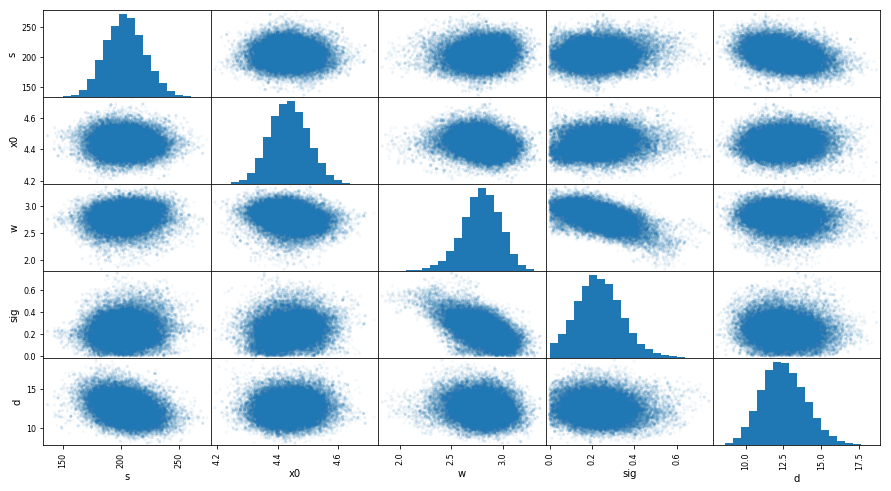

In [12]:
scatter_matrix(df, alpha=0.05, figsize=(15,8), hist_kwds={'bins':20})
plt.show()

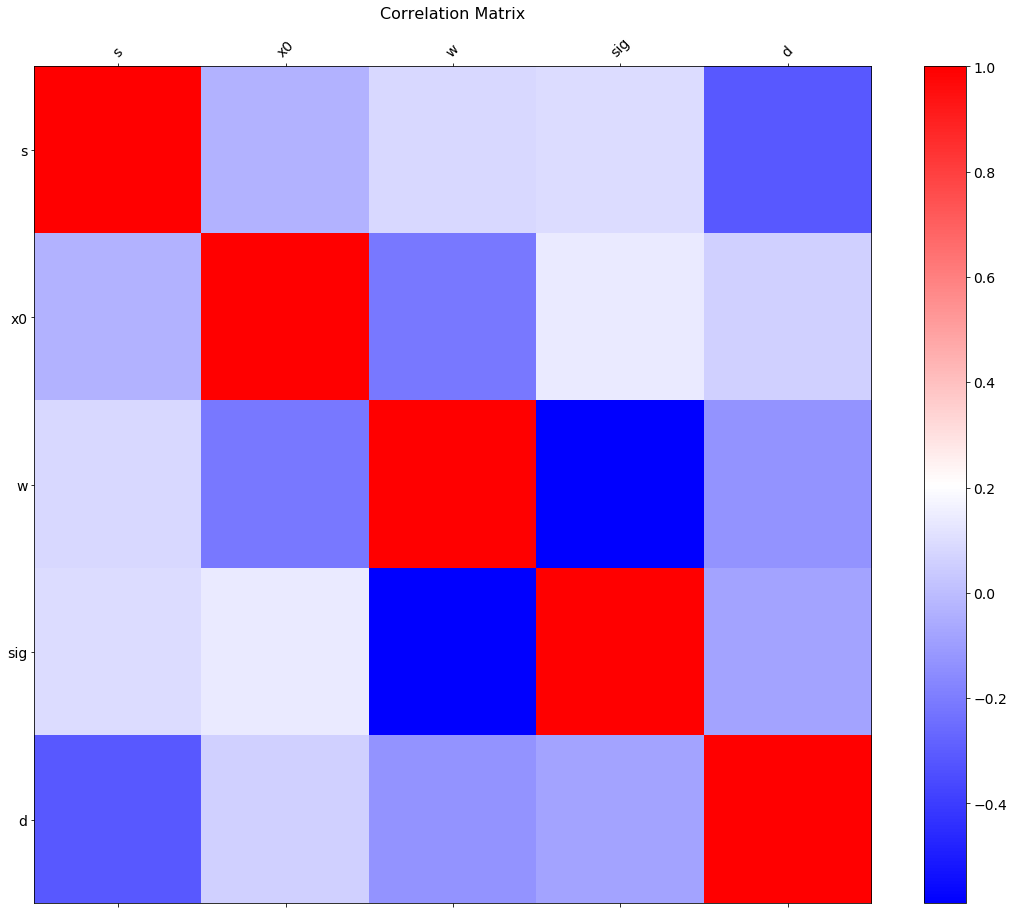

In [14]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number, cmap='bwr')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Get intervals and medians. 5% is the lower bound of the 90% Confidence interval and 95% is the upper bound of the 90% confidence interval. 50% is the median value.

In [11]:
df.describe(percentiles=[.05, .95]).loc[['5%', '50%', '95%']]

,s,x0,w,sig,d
5%,177.119940,4.333431,2.464009,0.063857,10.241801
50%,203.626812,4.435867,2.797227,0.231345,12.438275
95%,232.063082,4.545880,3.073691,0.426704,15.001975
